In [35]:
import torch
import numpy as np
import os
import pytorch_lightning as pl

from torchphysics.problem import Variable
from torchphysics.setting import Setting
from torchphysics.problem.domain import Interval
from torchphysics.problem.condition import (DirichletCondition,
                                            DiffEqBoundaryCondition,
                                            DiffEqCondition)
from torchphysics.models.fcn import SimpleFCN
from torchphysics import PINNModule
from torchphysics.utils import grad

from torchphysics.setting import Setting

os.environ["CUDA_VISIBLE_DEVICES"] = "0" # select GPUs to use

#pl.seed_everything(43) # set a global seed
torch.cuda.is_available()

False

In [36]:
# First define all parameters:
h_0 = 1.6e-02 #m = 16 um
delta_h = 1e-02 #m = 10 um 
D = 100 #m = 100 mm 
L = np.pi*D # Länge von Gebiet
u_m = 260 #mm/s 0.26 m/s
beta = 2.2*1e-02 # mm^2/N
nu_0 = 1.5e-09 # Ns/mm^2 = 1.5e-03 Pa·s = 1.5 mPa·s
p_0 = 1e-01 # N/mm^2 = 1 bar

In [37]:
# define h:
def h(x):
    return h_0 + delta_h * np.cos(2*x/D) # here use x/D, instead of x? Or else
    #return h_0                                   # the function is almost constant.

# we can analytically compute h':
def h_x(x):
    return -2.0*delta_h/D * np.sin(2*x/D) # x in [0,pi*D]
    #return 0

# create a data function, so we only need to evaluate h and h' once at the beginning
def data_fun(x):
    out_h = h(x)
    out_d_h = h_x(x)
    out = np.column_stack((out_h, out_d_h)) # column 0 : values of h
                                            # column 1 : values of h' 
    return out.astype(np.float32)

In [38]:
# define the function of the viscosity.
# Here we need torch.tensors, since the function will be evaluated in the pde.
# At the beginng the model will have values close to 0, 
# therefore the viscosity will also be close to zero. 
# This will make the pde condition unstable, because we divide by nu.
# For now set values smaller then 1e-06 to 1e-06 
def nu_func(p):
    out = nu_0 * torch.exp(beta * p)
    return torch.clamp(out, min=1e-12)

In [39]:
# Variables:
x = Variable(name='x',
             order=1,
             domain=Interval(0, L),
             train_conditions={},
             val_conditions={})
# Output:
p = 'p'

In [40]:
norm = torch.nn.MSELoss()

# periodic boundary -> use arbritray boundary conditon class:
time_points = 500 # number of time-points for the boundary condition.
# The points will be in such order, that the first points will be 
# at the left x-boundary, and the last points at the right side. 
# This will be consitent over all iterations, therefore we can compute
# the specific index once:
index_left = range(0, time_points)
index_right = range(time_points, 2*time_points)
def periodic_fun(p, x):
    #print('left', x[index_left]) # to check correct order of x
    return p[0]-p[1]
    #return rho[index_left]

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=periodic_fun,
                                              name='periodic_condition',
                                              norm=norm,
                                              weight=20.0,
                                              dataset_size=[2], # 2 points for x (left/right boundary)
                                              boundary_sampling_strategy='grid'))

def l_fun(p, x):
    #print('left', x[index_left]) # to check correct order of x
    return p-p_0
    #return rho[index_left]

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=l_fun,
                                              name='l_condition',
                                              norm=norm,
                                              dataset_size=[1], # 2 points for x (left/right boundary)
                                              sampling_strategy='grid',
                                              boundary_sampling_strategy='lower_bound_only'))
def r_fun(p, x):
    #print('left', x[index_left]) # to check correct order of x
    return p-p_0
    #return rho[index_left]

x.add_train_condition(DiffEqBoundaryCondition(bound_condition_fun=r_fun,
                                              name='r_condition',
                                              norm=norm,
                                              dataset_size=[1], # 2 points for x (left/right boundary)
                                              sampling_strategy='grid',
                                              boundary_sampling_strategy='upper_bound_only'))

In [41]:
def pde(p, x, data):
    # evaluate the viscosity
    nu = nu_func(p)
    # implemnet the PDE:
    # part1
    p_x = grad(p, x) 
    part = 6 * u_m * data[:, 1:]  # 6*u_m*grad(h,x)
    # part2
    diff = p_x/nu
    prod_1 = 3*data[:, :1]**2*data[:, 1:]*diff
    prod_2 = data[:, :1]**3 * grad(diff, x)
    diff = prod_1 + prod_2
    # Gesamtproblem
    return part-diff
   
train_cond = DiffEqCondition(pde=pde,
                             name='pde',
                             data_fun=data_fun,
                             norm=norm,
                             weight=1.0,
                             sampling_strategy='grid',
                             dataset_size=10000)

In [42]:
setup = Setting(variables=(x),
                train_conditions={'pde': train_cond},
                val_conditions={},
                solution_dims={p: 1},
                n_iterations=500)

In [43]:
solver = PINNModule(model=SimpleFCN(variable_dims=setup.variable_dims,
                                    solution_dims=setup.solution_dims,
                                    normalization_dict=setup.normalization_dict,
                                    depth=4,
                                    width=30),
                    optimizer=torch.optim.Adam,
                    lr=1e-3)

In [44]:
#solver.model.get_layers()

In [45]:
trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=15,
                     max_epochs=3,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.3 K 
------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\inu2sh\Desktop\Torch-Physics\_venv\lib\site-packages\pytorch_lightning\trainer\data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argumen

Training: 0it [00:00, ?it/s]

In [46]:
# Use LBFGS at the end
solver.lr = 0.01
solver.optimizer = torch.optim.LBFGS
solver.optim_params = {'max_iter': 1}
trainer = pl.Trainer(gpus=None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     check_val_every_n_epoch=20,
                     log_every_n_steps=15,
                     max_epochs=1,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver, setup)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type      | Params
------------------------------------
0 | model | SimpleFCN | 1.3 K 
------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

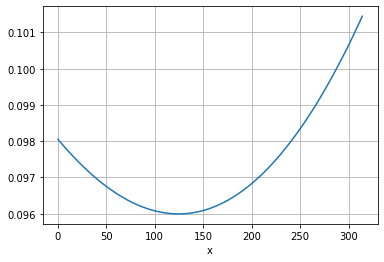

In [47]:
from torchphysics.utils.plot import _plot
#solver = solver.to('cpu')
fig = _plot(model=solver.model, solution_name='p', plot_variables=[x],
            points=500) 

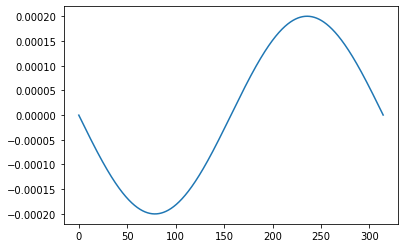

In [48]:
import matplotlib.pyplot as plo

plo.plot(setup.train_data['pde']['x'][:].detach().numpy(),
         setup.train_data['pde']['data'][:, 1].detach().numpy())